In [46]:
# calculate annual total fossil fuel emission for 
# ODIAC and EDGAR5
# and compare

In [47]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [48]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import regionmask
from util.functions import area_latlon
from util.gamap_colormap import WhGrYlRd

In [49]:
# GEOS-Chem default ffCO2 emission file, use it for output data format
gc_input_dir = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2019-12/'
ds_gc = xr.open_dataset(gc_input_dir + 'ODIAC_CO2.monthly.generic.1x1.nc')
ds_gc

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 180)
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2014-12-01
Data variables:
    CO2      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.5.6 (http://code.zmaw.de/p...
    Conventions:  COARDS
    Title:        COARDS/netCDF file created by BPCH2COARDS (GAMAP v2-03+)
    Model:        GENERIC
    Delta_Lon:    1.0
    Delta_Lat:    1.0
    NLayers:      1
    Start_Date:   20000101
    Start_Time:   0
    End_Date:     20141201
    End_Time:     0
    Delta_Time:   0
    CDO:          Climate Data Operators version 1.5.6.1 (http://code.zmaw.de...
    history:      Fri Apr 17 10:56:08 2015: ncatted -a axis,time,o,c,T ODIAC_...

In [50]:
# compute total ffCO2 emissions with available years of data
first_yr = 1990
last_yr  = 2018
eu28_names = ['United Kingdom', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
eu28_tmp = np.zeros(len(eu28_names))

In [51]:
# EDGAR
input_dir = '/exports/csce/datastore/geos/users/msadiq/'
year_vec_edgar = np.arange(first_yr, last_yr+1,1)
lat_res = 0.1
lon_res = 0.1
varname = 'emi_co2'
fname1 = 'EDGARv5/v50_CO2_excl_short-cycle_org_C_'
fname2 = '.0.1x0.1.nc'
sum_edgar_global = np.zeros(len(year_vec_edgar))
sum_edgar_eu28 = np.zeros(len(year_vec_edgar))

In [52]:
tmp = xr.open_dataset(input_dir+'EDGARv5/v50_CO2_excl_short-cycle_org_C_2016.0.1x0.1.nc')
dr = tmp['emi_co2']
# create country masks, for EU28
mask = regionmask.defined_regions.natural_earth.countries_110.mask(dr)

In [53]:
dr

<xarray.DataArray 'emi_co2' (lat: 1800, lon: 3600)>
[6480000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 0.05 0.15 0.25 0.35 ... 359.65 359.75 359.85 359.95
Attributes:
    standard_name:  tendency_of_atmosphere_mass_content_of_carbon_dioxide_due...
    long_name:      Emissions of CO2 - 
    units:          kg m-2 s-1
    cell_method:    time: mean (interval: 1 year, 366 days)
    total_emi_co2:     3.67531e+013 kg/year
    comment:         (see http://edgar.jrc.ec.europa.eu/methodology.php#12sou...

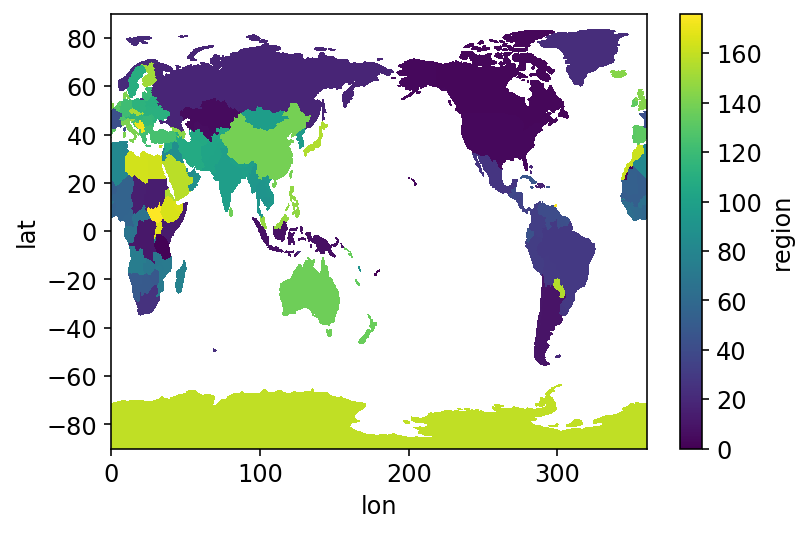

In [54]:
mask.plot()
mean_countries = dr.groupby(mask).mean('stacked_lat_lon')
names = regionmask.defined_regions.natural_earth.countries_110[mean_countries.region.values].names
mean_countries.coords['names'] = ('region', names)

In [55]:
mean_countries.names.values

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "CÃ´te d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', '

In [56]:
# loop over all of years of available ODIAC data,
# compute EU28 emission
# compute global emission
for i, iyear in enumerate(year_vec_edgar):
    ds_EDGAR = xr.open_dataset(input_dir + 
                               fname1 +
                               str(iyear) + 
                               fname2)
    data = ds_EDGAR[varname].copy()
    
    for ilat, lat in enumerate(data.lat):
        area_tmp = area_latlon(lat1 = lat, 
                               lon1 = data.lon[10].values, 
                               lat2 = lat + lat_res, 
                               lon2 = data.lon[10].values + lon_res)
        if(iyear in [1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020]): # leap years
            data[ilat,:] = data[ilat,:] * area_tmp *3600*24*366*1e6 # unit: kgCO2/yr
        else:
            data[ilat,:] = data[ilat,:] * area_tmp *3600*24*365*1e6 # unit: kgCO2/yr
    annual_edgar = data.copy()
    total_edgar = data.sum()                      # kgCO2/yr
    ann_total = total_edgar.values*1e-12          # GtCO2/yr
    ann_total_C = total_edgar.values*1e-12*12/44  # GtC/yr
    
    # global total
    sum_edgar_global[i] = ann_total
    print(str(iyear), ' global annual emission: ' + str(sum_edgar_global[i]))
    
    # EU28 calculation
    sum_countries = annual_edgar.groupby(mask).sum('stacked_lat_lon')
    sum_countries.coords['names'] = ('region', names)
    eu28_tmp = np.zeros(len(eu28_names))
    for count, name in enumerate(eu28_names):
        eu28_tmp[count] = sum_countries.isel(region=(sum_countries.names == eu28_names[count]))
    
    sum_edgar_eu28[i] = sum(eu28_tmp)*1e-12 # GtCO2/yr
    print(str(iyear), ' EU28 annual emission: ' + str(sum_edgar_eu28[i]))
    

1990  global annual emission: 22.62063644672
1990  EU28 annual emission: 4.309843280128
1991  global annual emission: 22.737984684032
1991  EU28 annual emission: 4.2588433264639995
1992  global annual emission: 22.668562661376
1992  EU28 annual emission: 4.10740385792
1993  global annual emission: 22.767713910784
1993  EU28 annual emission: 4.026770161152
1994  global annual emission: 22.98852933632
1994  EU28 annual emission: 4.007972875776
1995  global annual emission: 23.640011702271998
1995  EU28 annual emission: 4.052490051072
1996  global annual emission: 24.106315546624
1996  EU28 annual emission: 4.1632431872
1997  global annual emission: 24.441899712512
1997  EU28 annual emission: 4.078482040832
1998  global annual emission: 24.528988143616
1998  EU28 annual emission: 4.072385868288
1999  global annual emission: 24.726927835136
1999  EU28 annual emission: 4.008809642496
2000  global annual emission: 25.584010788864
2000  EU28 annual emission: 4.03327151104
2001  global annual 

In [57]:
# Paris Agreement goal for EU28, after 2018
after_year_vector = [2018,2031]
after_2018 = np.empty(len(after_year_vector))
after_2018[0] = sum_edgar_eu28[-1]
after_2018[1] = sum_edgar_eu28[0]*0.6

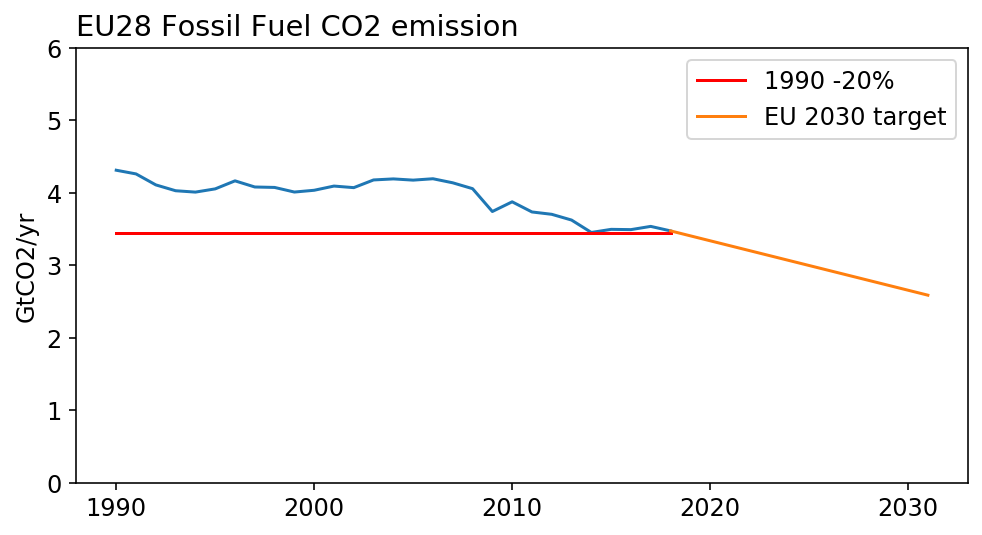

In [58]:
# plot of emission evolution for EU28, and future reduction plan

fig = plt.figure(figsize=[8, 4])
plt.title('EU28 Fossil Fuel CO2 emission', loc='left')

plt.plot(year_vec_edgar, sum_edgar_eu28)
plt.plot(year_vec_edgar, np.repeat(sum_edgar_eu28[0]*0.8,len(sum_edgar_eu28)), 'r', label = '1990 -20%')
plt.plot(after_year_vector, after_2018, label = 'EU 2030 target')

plt.ylim(0,6)
plt.ylabel('GtCO2/yr')
plt.legend()

fig.savefig('/geos/u73/msadiq/co2_data/extract/plots/eu2020_2030.png', dpi=300)

In [59]:
# ODIAC
input_dir = '/exports/csce/datastore/geos/users/msadiq/'
first_year = 2000
last_year = 2018
year_vec_odiac = np.arange(first_year, last_year+1, 1)
lat_res = 1.
lon_res = 1.
varname1 = 'land'
varname2 = 'intl_bunker'
fname1 = 'odiac/odiac2019_1x1d_'
fname2 = '.nc'
sum_odiac_global = np.zeros(len(year_vec_odiac))

In [60]:
ds_odiac = xr.open_dataset(input_dir+'odiac/odiac2019_1x1d_2016.nc')
ds_odiac['land'] #.attrs#['global_total'] #['intl_bunker'][:,:,1].plot()

<xarray.DataArray 'land' (month: 12, lat: 180, lon: 360)>
[777600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:       gC/m2/d
    long_name:   ffco2_emission
    definition:  CO2 emissions from fossil fuel combustion, cememt production...

In [61]:
# output these emissions to match GEOS-Chem emission format
date_gc = np.repeat(np.datetime64('2000-01-01', 'ns'), 12*len(year_vec_odiac))
tmp = np.arange('2000', '2019', dtype='datetime64[M]')

for i,idate in enumerate(tmp): 
    tmp1 = str(idate) + '-01'
    date_gc[i] = np.datetime64(tmp1, 'ns')
time = date_gc
foo = xr.DataArray(0., coords=[time, ds_gc.lat, ds_gc.lon], dims=['time', 'lat', 'lon'])
target = foo.to_dataset(name = 'CO2')

In [62]:
for i,iyear in enumerate(year_vec_odiac):
    ds_data = xr.open_dataset(input_dir + 
                               fname1 +
                               str(iyear) + 
                               fname2)
    data = ds_data[varname1] + ds_data[varname2]
    # store data for output
    foo[i*12:(i+1)*12,:,:] = data/(24*3600*1000) *44/12 # to kgCO2/m2/s
    
    if(iyear in [1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020]): # leap years
        days_in_month = [31,29,31,30,31,30,31,31,30,31,30,31]
    else:
        days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

    for ilat, lat in enumerate(data.lat):
        for imonth in range(12):
            area_tmp = area_latlon(lat1 = lat, 
                                   lon1 = data.lon[10].values, 
                                   lat2 = lat + lat_res, 
                                   lon2 = data.lon[10].values + lon_res)
            data[imonth, ilat,:] = data[imonth, ilat,:] * area_tmp * days_in_month[imonth] *1e-3 # unit: kgCO2/month
    annual = data.copy()
    total = data.sum()             # kgCO2/year, same as data description
    ann_total = total.values*1e-6*44/12  # GtCO2/yr
    
    sum_odiac_global[i] = ann_total
    print(str(iyear), ' global annual emission: ' + str(sum_odiac_global[i]))


2000  global annual emission: 24.769040999999998
2001  global annual emission: 24.918393499999997
2002  global annual emission: 25.524124999999998
2003  global annual emission: 26.934138
2004  global annual emission: 28.170398666666667
2005  global annual emission: 29.315619666666667
2006  global annual emission: 30.314751499999996
2007  global annual emission: 30.83366
2008  global annual emission: 31.914765666666668
2009  global annual emission: 31.07664633333333
2010  global annual emission: 33.232070666666665
2011  global annual emission: 34.323138666666665
2012  global annual emission: 35.08588966666667
2013  global annual emission: 35.523081
2014  global annual emission: 35.619917666666666
2015  global annual emission: 35.756259
2016  global annual emission: 35.77822233333333
2017  global annual emission: 36.019188333333325
2018  global annual emission: 36.47463966666666


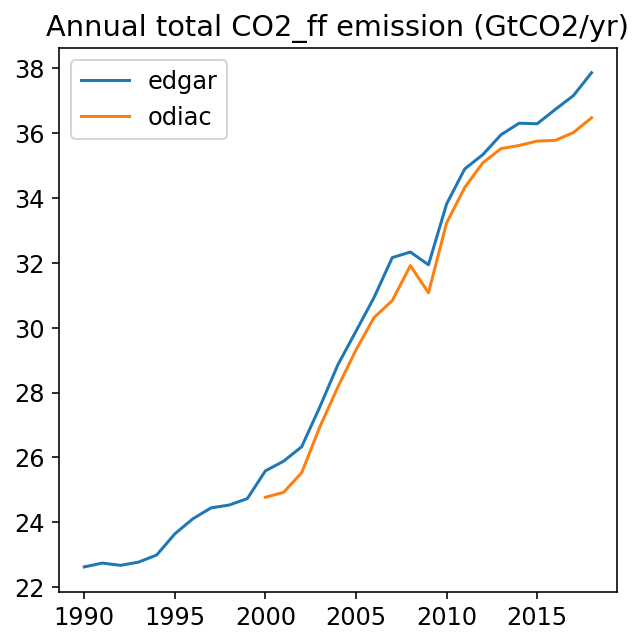

In [63]:
# plot both lines
fig = plt.figure(figsize=[5, 5])
width = 0.3

plt.plot(year_vec_edgar, sum_edgar_global, label = 'edgar')
plt.plot(year_vec_odiac, sum_odiac_global, label = 'odiac')
plt.title('Annual total CO2_ff emission (GtCO2/yr)', loc='center')
plt.legend()

fig.savefig('/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/annual_total_longest.png', dpi=300)

In [64]:
# check data stored in foo, if the unit is correct
data = foo[216:228,:,:].copy() # 2018 monthly from ODIAC, kgCO2/m2/s
    
for ilat, lat in enumerate(data.lat):
    for imonth in range(12):
        area_tmp = area_latlon(lat1 = lat, 
                            lon1 = data.lon[10].values, 
                            lat2 = lat + lat_res, 
                            lon2 = data.lon[10].values + lon_res) # km^2
        days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
        data[imonth, ilat,:] = data[imonth, ilat,:]*area_tmp*days_in_month[imonth]*3600*24*1e6 # unit: kgCO2/month

    total = data.sum()             # kgCO2/year, same as data description
    ann_total = total.values*1e-12 # GtCO2/yr

ann_total # correct

36.47463864229678

In [65]:
# make sure output format matches GEOS-Chem emission format
foo = foo.astype('float32')
foo.attrs = ds_gc['CO2'].attrs
ds_output = foo.to_dataset(name = 'CO2')
ds_output.attrs = ds_gc.attrs
ds_output.attrs['End_Date'] = '20181201'
ds_output.attrs['history'] = 'Processed by Mehliyar Sadiq, April 2020'
ds_output.to_netcdf('/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/ODIAC_CO2.monthly.Sadiq.1x1.nc')

